Juan Esteban Puyo

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import numpy as np

The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [2]:
train_dataset = datasets.CIFAR10('../data', train=True, download=True,
                                     transform=transforms.ToTensor())
train_data = train_dataset.data

# Calculate the mean and standard deviation
mean = np.mean(train_data) / 255.0
std = np.std(train_data) / 255.0

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")




100%|██████████| 170M/170M [00:07<00:00, 21.9MB/s]


Mean: 0.4733630004850899
Standard Deviation: 0.2515689250632208


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                #DATA AUGMENTATION
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
                               transforms.Normalize((0.47,),(0.25,),)]) #mean and std have to be sequences (e.g., tuples),
                                                                      # therefore we should add a comma after the values

# load the data: train and test sets
trainset = datasets.CIFAR10('../data', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('../data', download=True, train=False, transform=transform)

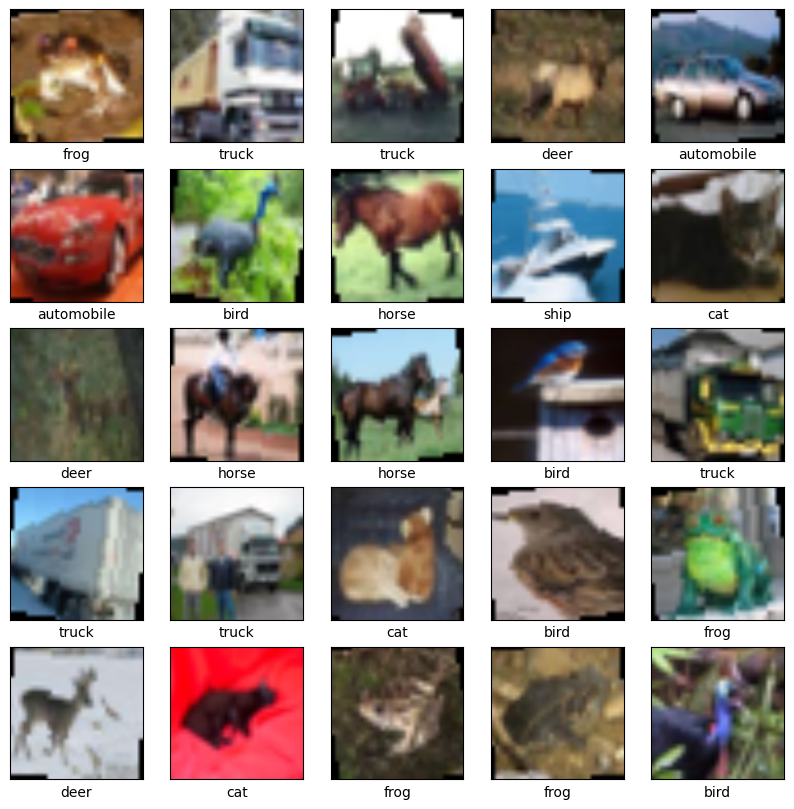

In [4]:
from matplotlib import pyplot as plt

class_names = ['airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img, label = trainset[i]

    # Denormalize the image
    mean = 0.4733630004850899
    std = 0.2515689250632208
    img = img * std + mean

    # Transpose the image from (channels, height, width) to (height, width, channels)
    plt.imshow(img.permute(1, 2, 0))
    plt.xlabel(class_names[label])
plt.show()

In [5]:
batch_size = 64  # Reduced batch size to mitigate OutOfMemoryError
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False) # , drop_last=False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
model_ft = models.vgg16(weights="IMAGENET1K_V1")
model_ft.to(device)
num_classes = 10 # I previously know that the CIFAR 10 must have 10 classes to classify

for param in model_ft.parameters():
  param.requires_grad = False

from torchsummary import summary
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
#summary(model_ft, (3, 32, 32))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 189MB/s]


In [18]:
def train(model_ft, trainloader, validloader, device, optimizer, epochs=10):
  """
  Trains a PyTorch model and returns the training and validation losses.

  Args:
    model: The PyTorch model to train.
    trainloader: The DataLoader for the training set.
    validloader: The DataLoader for the validation set.
    epochs: The number of training epochs.
    learning_rate: The learning rate for the optimizer.

  Returns:
    train_losses: A list of training losses for each epoch.
    valid_losses: A list of validation losses for each epoch.
  """
  criterion = nn.CrossEntropyLoss()

  # Move model to the device
  model_ft.to(device)

  train_losses = []
  valid_losses = []

  for epoch in range(epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in trainloader:
      images, labels = images.to(device), labels.to(device) # Move data to the correct device
      optimizer.zero_grad()
      outputs = model_ft(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
      for images, labels in validloader:
        images, labels = images.to(device), labels.to(device) # Move data to the correct device
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    valid_loss = running_loss / len(validloader)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

  return train_losses, valid_losses

In [9]:
# function for evaluation/test
def test(model_ft, device, test_loader):
    model_ft.eval()  # model to eval
    test_loss = 0
    correct = 0

    # ITERATE DATALOADER: test_loader
    for data, target in test_loader:
        batch_size = data.shape[0]
        data, target = data.to(device), target.to(device)
        output = model_ft(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # sanity check
        pred = pred.view(batch_size)  # [bs,]
        target = target.view(batch_size)  # [bs,]

        # compute prediction ok
        batch_pred_ok = pred.eq(target).sum().item()
        correct += batch_pred_ok

    test_loss /= len(test_loader.dataset)
    num_samples = len(test_loader.dataset)
    test_accuracy = correct / num_samples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
lr = 0.01
num_epochs = 3
print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_dataset)/batch_size)}")

lr: 0.01
batch size: 64
Num. optimization steps per-epoch: 781


In [13]:
#############
# OPTIMIZER #
#############
parameters_to_optimize = model_ft.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

In [19]:
train_losses, valid_losses = train(model_ft, trainloader, testloader, device, optimizer, num_epochs)

Epoch [1/3], Train Loss: 4.2635, Valid Loss: 3.2207
Epoch [2/3], Train Loss: 4.8996, Valid Loss: 3.3745
Epoch [3/3], Train Loss: 4.8488, Valid Loss: 4.1222


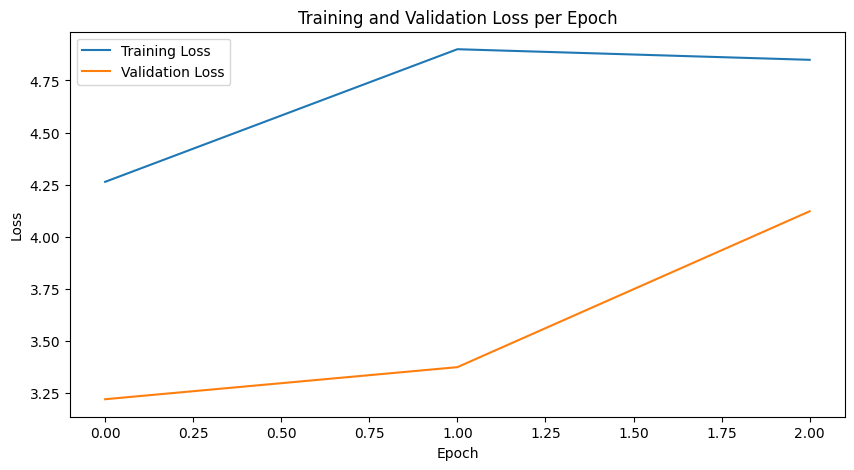

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

#Finetunning

In [25]:
#first unfreezing the layers to perform fine tunning

for param in model_ft.parameters():
  param.requires_grad = True

In [21]:
model_ft = models.vgg16(weights="IMAGENET1K_V1")
model_ft.to(device)
num_classes = 10 # I previously know that the CIFAR 10 must have 10 classes to classify

from torchsummary import summary


num_ftrs = model_ft.classifier[6].in_features
#finetunning


# Additional linear layer and dropout layer
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

In [22]:
train_losses, valid_losses = train(model_ft, trainloader, testloader, device, optimizer, num_epochs)

Epoch [1/3], Train Loss: 15.2277, Valid Loss: 12.6619
Epoch [2/3], Train Loss: 15.2308, Valid Loss: 12.6692
Epoch [3/3], Train Loss: 15.2119, Valid Loss: 12.6820


In [23]:
test(model_ft, device, testloader)


Test set: Average loss: 12.6846, Accuracy: 0/10000 (0%)



#Fine tunning partial layers

In [26]:
# Inspect model layers
for name, param in model_ft.named_parameters():
    print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias
fc.0.weight
fc.0.bias
fc.3.weight
fc.3.bias


Now that you can see the layer names, you can choose which ones to unfreeze. For partial fine-tuning, it's common to unfreeze the later convolutional blocks and the classifier. Here's an example of how to unfreeze the last two convolutional blocks (features.24 through features.30) and the classifier layers:

In [27]:
# Implement partial fine-tuning
for name, param in model_ft.named_parameters():
    if 'features.24' in name or 'features.27' in name or 'features.30' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Verify which layers are trainable
print("Trainable layers after partial fine-tuning:")
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        print(name)

Trainable layers after partial fine-tuning:
features.24.weight
features.24.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [ ]:
# Additional linear layer and dropout layer
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

# Adding warm up stage

In [29]:
def train_with_warmup(model_ft, trainloader, validloader, device, optimizer, epochs=10, warmup_epochs=0):
    """
    Trains a PyTorch model with a warm-up stage and returns the training and validation losses.

    Args:
      model: The PyTorch model to train.
      trainloader: The DataLoader for the training set.
      validloader: The DataLoader for the validation set.
      epochs: The number of training epochs.
      device: The device to train on (cpu or cuda).
      optimizer: The optimizer to use.
      warmup_epochs: The number of epochs for the warm-up stage.

    Returns:
      train_losses: A list of training losses for each epoch.
      valid_losses: A list of validation losses for each epoch.
    """
    criterion = nn.CrossEntropyLoss()

    # Move model to the device
    model_ft.to(device)

    # Initialize the warm-up scheduler
    if warmup_epochs > 0:
        # Calculate the number of training steps per epoch
        steps_per_epoch = len(trainloader)
        # Total number of warm-up steps
        n_warmup_steps = warmup_epochs * steps_per_epoch

        # Define the warm-up lambda function
        warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: min((step + 1) / n_warmup_steps, 1.0)
        )


    train_losses = []
    valid_losses = []

    # Keep track of the global step for the warm-up scheduler
    global_step = 0

    for epoch in range(epochs):
        model_ft.train()  # Set the model to training mode
        running_loss = 0.0
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)  # Move data to the correct device
            optimizer.zero_grad()
            outputs = model_ft(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Step the warm-up scheduler if within the warm-up period
            if warmup_epochs > 0 and global_step < n_warmup_steps:
                warmup_scheduler.step()

            running_loss += loss.item()
            global_step += 1 # Increment global step

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Validation
        model_ft.eval()  # Set the model to evaluation mode
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)  # Move data to the correct device
                outputs = model_ft(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(validloader)
        valid_losses.append(valid_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    return train_losses, valid_losses

In [30]:
def test_updated(model_ft, device, test_loader):
    """
    Evaluates a PyTorch model on the test set.

    Args:
        model_ft: The PyTorch model to evaluate.
        device: The device to evaluate on (cpu or cuda).
        test_loader: The DataLoader for the test set.
    """
    model_ft.eval()  # model to eval
    test_loss = 0
    correct = 0

    # ITERATE DATALOADER: test_loader
    with torch.no_grad():
        for data, target in test_loader:
            batch_size = data.shape[0]
            data, target = data.to(device), target.to(device)
            output = model_ft(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # sanity check
            pred = pred.view(batch_size)  # [bs,]
            target = target.view(batch_size)  # [bs,]

            # compute prediction ok
            batch_pred_ok = pred.eq(target).sum().item()
            correct += batch_pred_ok

    test_loss /= len(test_loader.dataset)
    num_samples = len(test_loader.dataset)
    test_accuracy = correct / num_samples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [31]:
warmup_epochs = 5 # You can adjust this number
train_losses_warmup, valid_losses_warmup = train_with_warmup(model_ft, trainloader, testloader, device, optimizer, num_epochs, warmup_epochs)

Epoch [1/3], Train Loss: 15.2105, Valid Loss: 12.6783
Epoch [2/3], Train Loss: 15.2155, Valid Loss: 12.6722
Epoch [3/3], Train Loss: 15.2194, Valid Loss: 12.6633


In [32]:
test_updated(model_ft, device, testloader)


Test set: Average loss: 12.6667, Accuracy: 0/10000 (0%)



#Without Data Augmentation

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.47,),(0.25,),)]) #mean and std have to be sequences (e.g., tuples),
                                                                      # therefore we should add a comma after the values

# load the data: train and test sets
trainset = datasets.CIFAR10('../data', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('../data', download=True, train=False, transform=transform)

## Another "Scheduler for warm up stage"

In [28]:
from torch.optim.lr_scheduler import _LRScheduler
import math

class LinearWarmupScheduler(_LRScheduler):
    """Linearly increases the learning rate from 0 to initial_lr."""

    def __init__(self, optimizer, warmup_epochs, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch >= self.warmup_epochs:
            return self.base_lrs
        # Linearly increase learning rate from 0 to base_lr
        return [base_lr * (self.last_epoch + 1) / self.warmup_epochs for base_lr in self.base_lrs]

# Example usage:
# Define your optimizer
# optimizer = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

# Define the number of warm-up epochs
# warmup_epochs = 5

# Create the warm-up scheduler
# scheduler = LinearWarmupScheduler(optimizer, warmup_epochs)

# In your training loop, after optimizer.step():
# scheduler.step()

# You can combine this with another scheduler for after the warm-up, e.g., StepLR
# from torch.optim.lr_scheduler import StepLR
# after_warmup_scheduler = StepLR(optimizer, step_size=some_step_size, gamma=some_gamma)

# In your training loop, after scheduler.step() and if warm-up is done:
# if self.last_epoch >= self.warmup_epochs:
#     after_warmup_scheduler.step()